# 序列模型

假设有 T 个时间步，每个时间步对应一个值 $x_t$ $\left(t \in T\right)$

序列模型：对 T 个不独立的随机变量建模

$$p(\mathbf{x})=p\left(x_1\right) \cdot p\left(x_2 \mid x_1\right) \cdot p\left(x_3 \mid x_1, x_2\right) \cdot \ldots p\left(x_T \mid x_1, \ldots x_{T-1}\right)$$

自回归模型：使用自身过去数据预测未来

$$p\left(x_t \mid x_1, \ldots x_{t-1}\right)=p\left(x_t \mid f\left(x_1, \ldots x_{t-1}\right)\right)$$

自回归模型建模方案：

- 方案A：马尔可夫假设，当前数据只跟过去 $\tau$ 个数据点相关
$$
p\left(x_t \mid x_1, \ldots x_{t-1}\right)=p\left(x_t \mid x_{t-\tau}, \ldots x_{t-1}\right)=p\left(x_t \mid f\left(x_{t-\tau}, \ldots x_{t-1}\right)\right)
$$

- 方案B：潜变量模型，引入潜变量 $h_t = f(x_1, \ldots x_{t-1})$ 表示过去信息，$x_t = p( x_t | h_t, x_{t-1} )$

## 马尔可夫假设 + MLP

In [1]:
# !pip install torch torchvision

In [2]:
import torch
import matplotlib.pyplot as plt

In [3]:
%%time
import d2l_torch as d2l

CPU times: user 1.53 s, sys: 268 ms, total: 1.79 s
Wall time: 1.96 s


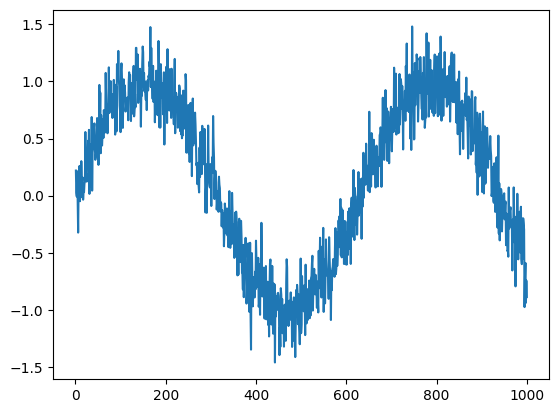

In [4]:
# 原函数
T = 1000
time = torch.arange(1, T+1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
plt.plot(time, x)

In [5]:
# 构造特征和标签
tau = 4
features = torch.zeros((T - tau, tau))  # T - tau: 样本数  tau: 样本特征数
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1, 1))

features.shape, labels.shape

(torch.Size([996, 4]), torch.Size([996, 1]))

In [6]:
# 分割训练集和验证集
batch_size, n_train = 16, 600
dataset = torch.utils.data.TensorDataset(features[:n_train], labels[:n_train])
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

In [7]:
# 神经网络：两个全连接层 4 -> 10, 10 -> 1
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

def get_net():
    net = torch.nn.Sequential(torch.nn.Linear(tau, 10), torch.nn.ReLU(), torch.nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = torch.nn.MSELoss()

In [8]:
def train(train_iter, net, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)  # 
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()  # 梯度设成零
            l = loss(net(X), y)  # 计算 loss 
            l.backward()  # 求导
            trainer.step()  # 更新
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss)}')

net = get_net()
train(train_iter, net, loss, 8, 0.01)

epoch 1, loss: 0.06778579376834004
epoch 2, loss: 0.05055887178566895
epoch 3, loss: 0.04799051563206472
epoch 4, loss: 0.04586806182602519
epoch 5, loss: 0.04718246200661126
epoch 6, loss: 0.0456314457972583
epoch 7, loss: 0.04746200163897715
epoch 8, loss: 0.04582639215023894


In [9]:
feats = torch.tensor([1.0 for _ in range(tau)])
net(feats).detach()

tensor([1.0130])

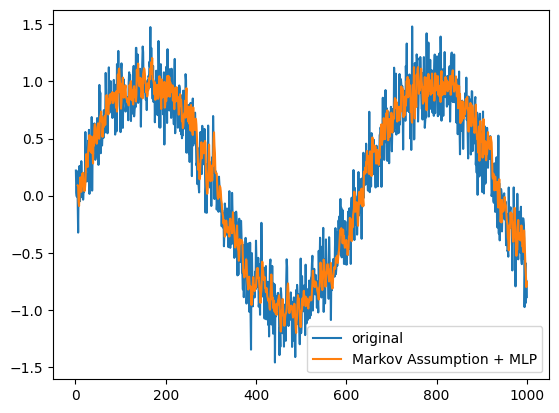

In [10]:
# 对于每个数据点，用该数据点的前4个点做预测
plt.plot(time, x, label='original')
plt.plot(time[tau:], net(features).detach().numpy(), label='Markov Assumption + MLP')
plt.legend()

In [11]:
# 给定前600个点，预测后400个点。基于预测的结果做预测
n2_train = 700
multistep_preds = torch.zeros(T)
multistep_preds[:n2_train + tau] = x[:n2_train + tau]
for i in range(n2_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i])

multistep_preds.detach().numpy().shape

(1000,)

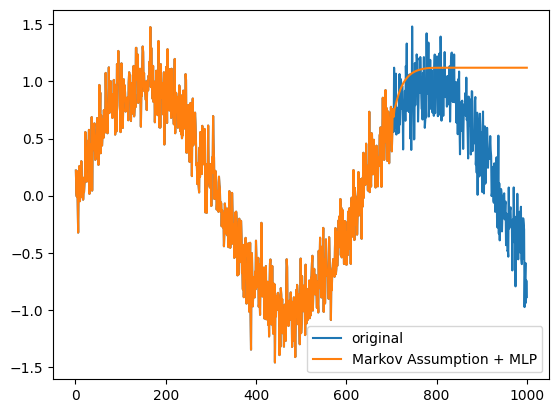

In [12]:
plt.plot(time, x, label='original')
plt.plot(time, multistep_preds.detach().numpy(), label='Markov Assumption + MLP')
plt.legend()